<a href="https://colab.research.google.com/github/Natali-bali/aquarium_fish_detection/blob/main/Aquarium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Find Nemo
In this notebook I will detect image of Nemo, I will use a pretrained CNN to recognize objects in a photograph of aquarium.

*Tasks from tutorial*:

- Chop up the image into slices of 224x224 pixels,
- Predict labels using a pre-trained network (e.g. MobileNet),
- Collect labels / predictions for all slices,
- Filter out predictions that are below a certain probability threshold,
- Analyze the results

### Download packeges

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras import backend as K
from os import listdir
from os.path import isfile, join

### Download Photograph of Aquarium

In [120]:
aquarium_image = image.load_img('/content/drive/MyDrive/projects/SPICED/weekly_codes/week9/project/aquarium/aquarium.jpg')
aquarium_image_array = image.img_to_array(aquarium_image)
aquarium_image_array.shape

(1080, 1920, 3)

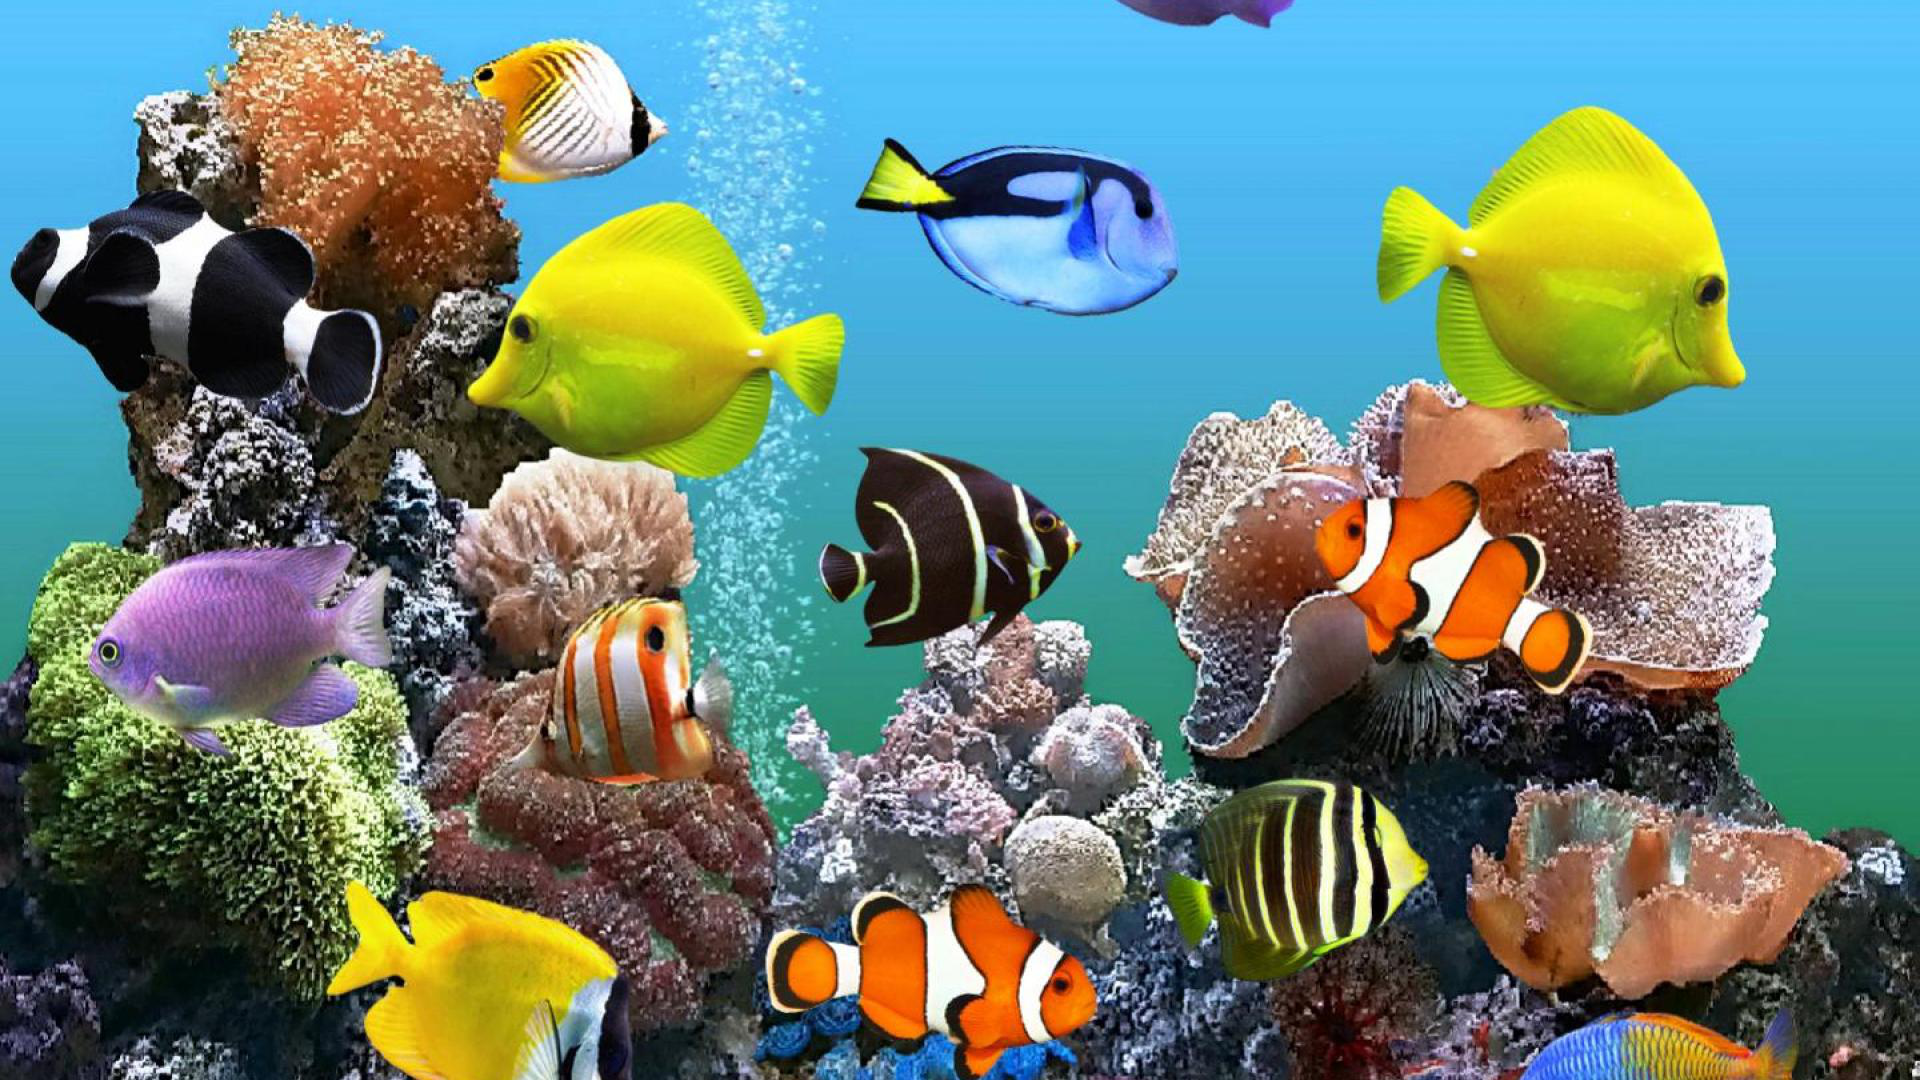

In [75]:
aquarium_image

In [76]:
aquarium_image_array[0][0]

array([ 86., 197., 253.], dtype=float32)

### Extract a single 1x224x224x3 slice of the image

(1, 224, 224, 3)

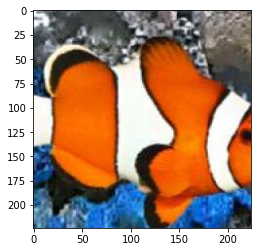

In [47]:
fish = aquarium_image_array[856:1080, 840:1064, :]
plt.imshow(fish/255.)
fish = np.expand_dims(fish, axis=0)
fish.shape

In [48]:
fish[0][0][0]

array([244., 251., 255.], dtype=float32)

### Check GPU

In [7]:
!nvidia-smi

Wed Jun 16 10:14:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mobilenet model to predict single picture
We're going to use pretrained on Imagenet dataset model MobileNet since it's small and works decently well out-of-the-box.

We are not going to train our model, just use it for prediction as it is

In [8]:
K.clear_session()

In [9]:
model_1 = MobileNetV2(weights='imagenet', include_top=True, classifier_activation="softmax")

14540800/14536120 [==============================] - 1s 0us/step


In [10]:
model_1.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
pred_1 = model_1.predict(fish)

In [50]:
decode_predictions(pred_1)

[[('n04209239', 'shower_curtain', 0.47989243),
  ('n03938244', 'pillow', 0.40823096),
  ('n03485794', 'handkerchief', 0.020964326),
  ('n04591157', 'Windsor_tie', 0.005351458),
  ('n02834397', 'bib', 0.0040511778)]]

We didn't get any result in this case

### VGG16 pretrained model to predict single image

In [41]:
K.clear_session()

In [42]:
model_2 = VGG16(weights='imagenet', 
                include_top=True, 
                classifier_activation="softmax",
                input_shape=(224,224,3),
                classes = 1000)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

553467904/553467096 [==============================] - 20s 0us/step


In [51]:
pred_2 = model_2.predict(fish)
decode_predictions(pred_2)

[[('n01924916', 'flatworm', 0.97399956),
  ('n01950731', 'sea_slug', 0.015279983),
  ('n02877765', 'bottlecap', 0.001997015),
  ('n03476684', 'hair_slide', 0.0016206532),
  ('n02606052', 'rock_beauty', 0.00069908676)]]

Better results(at least some marine life)

I try to preprocess input  

In [52]:
preprocessed_fish = preprocess_input(fish, data_format=None)

In [53]:
pred_2_prep = model_2.predict(preprocessed_fish)
decode_predictions(pred_2_prep)

[[('n02607072', 'anemone_fish', 0.8588035),
  ('n02606052', 'rock_beauty', 0.11658677),
  ('n09256479', 'coral_reef', 0.014332509),
  ('n01924916', 'flatworm', 0.005578426),
  ('n01914609', 'sea_anemone', 0.0040191547)]]

Now we've got very good results! Let's check first model

In [60]:
pred_1_prep = model_1.predict(preprocessed_fish)
decode_predictions(pred_1_prep)

[[('n03459775', 'grille', 0.16443898),
  ('n03691459', 'loudspeaker', 0.100772835),
  ('n04418357', 'theater_curtain', 0.094672196),
  ('n02892767', 'brassiere', 0.029957049),
  ('n04069434', 'reflex_camera', 0.02890638)]]

### Collect multiple slices / "tiles" by looping over the image.

In [135]:
tiles=[]
for x in range(0, 1920+1, 112):
  for y in range(0, 1080+1, 112):
    tile = aquarium_image_array[y:y+224, x:x+224, :]
    if tile.shape == (224, 224, 3):
      tiles.append(tile)

In [81]:
#aquarium_image_array[0][0]
#array([-37.68 ,  80.221, 149.061], dtype=float32)
#very strange bug, preprocess_input transforms also our main image to negative numbers
# i try to do this separate

array([-37.68 ,  80.221, 149.061], dtype=float32)

In [124]:
len(tiles)

128

### Plot tiles

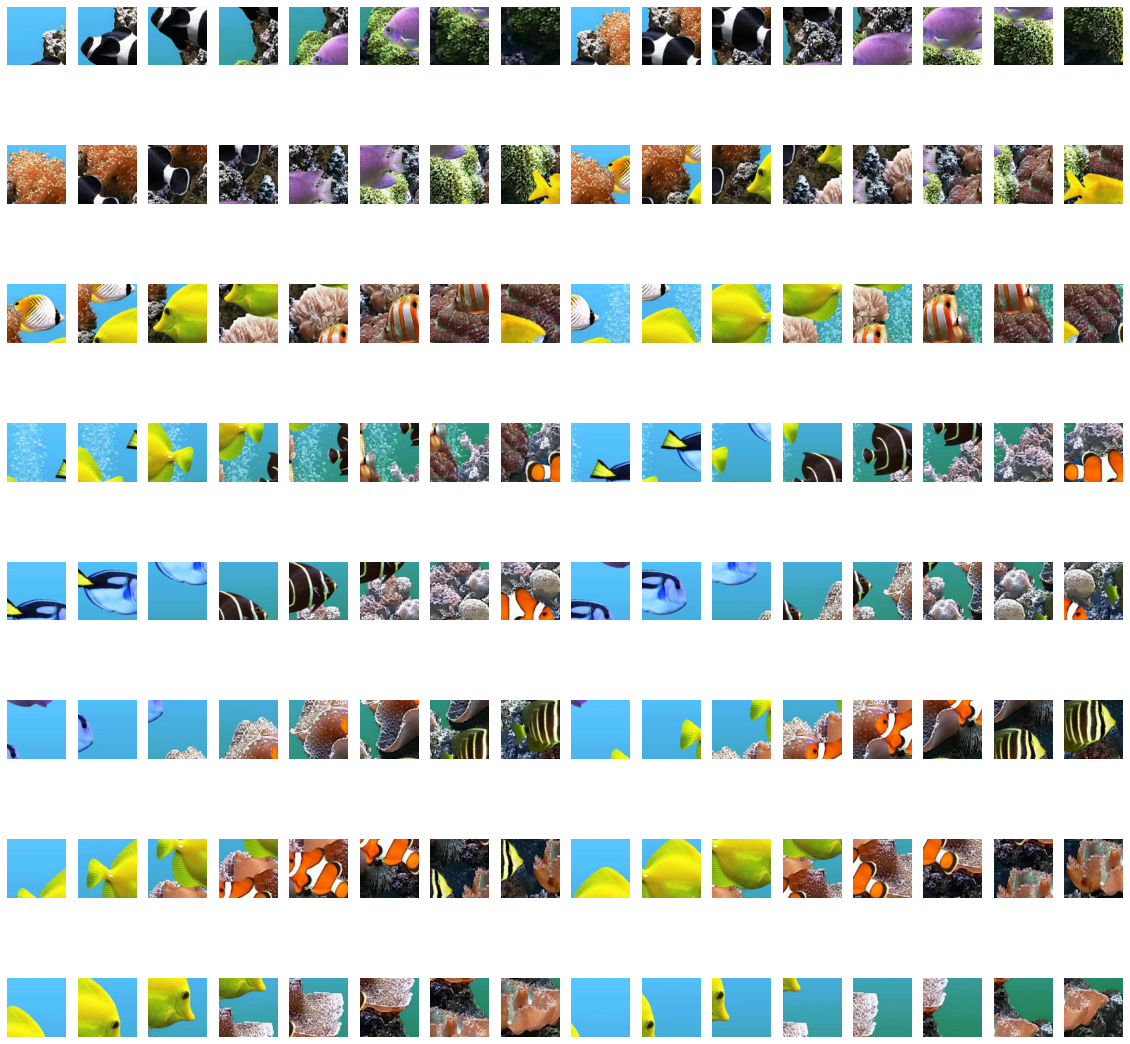

In [136]:
plt.figure(figsize=(20,20))
for tile, num in zip(tiles, range(len(tiles))):
  plt.subplot(8, int(len(tiles)/8), num+1)
  plt.imshow(tile/255.)
  plt.axis('off')

In [127]:
tiles = np.array(tiles)
tiles.shape

(128, 224, 224, 3)

In [128]:
preprocessed_tiles = []
for tile in tiles:
  preprocessed_tile = preprocess_input(tile, data_format = 'channels_last')     
  preprocessed_tiles.append(preprocessed_tile)

In [137]:
len(preprocessed_tiles)

128

### Make predictions on all tiles

In [138]:
result = []
for tile in preprocessed_tiles:
    tile = np.expand_dims(tile, axis=0)
    predictions = model_2.predict(tile)
    result.append(decode_predictions(predictions))

In [139]:
aquarium_image_array[0][0] #with setting chanel_last other pictures remain same

array([ 86., 197., 253.], dtype=float32)

In [140]:
for r in result:
  print(f'Predicted {r[0][0:2][0][1]} with accuracy {round(r[0][0:2][0][2]*100, 1)}% or {r[0][0:2][1][1]} with accuracy {round(r[0][0:2][1][2]*100, 1)}%')

Predicted bighorn with accuracy 17.0% or ibex with accuracy 6.2%
Predicted killer_whale with accuracy 35.3% or magpie with accuracy 13.3%
Predicted killer_whale with accuracy 74.2% or magpie with accuracy 16.4%
Predicted rock_beauty with accuracy 19.9% or killer_whale with accuracy 5.8%
Predicted rock_beauty with accuracy 87.8% or tench with accuracy 5.2%
Predicted rock_beauty with accuracy 89.7% or tench with accuracy 7.0%
Predicted puffer with accuracy 35.7% or axolotl with accuracy 19.1%
Predicted hen-of-the-woods with accuracy 4.0% or American_black_bear with accuracy 3.0%
Predicted hen-of-the-woods with accuracy 28.5% or coral_reef with accuracy 27.8%
Predicted teddy with accuracy 23.3% or rock_beauty with accuracy 6.9%
Predicted rock_beauty with accuracy 60.5% or anemone_fish with accuracy 10.2%
Predicted rock_beauty with accuracy 24.0% or killer_whale with accuracy 20.7%
Predicted rock_beauty with accuracy 83.1% or tench with accuracy 7.7%
Predicted rock_beauty with accuracy 81.

### Plot results

In [97]:
tiles[0][0]

array([[-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 149.061],
       [-37.68 ,  80.221, 14

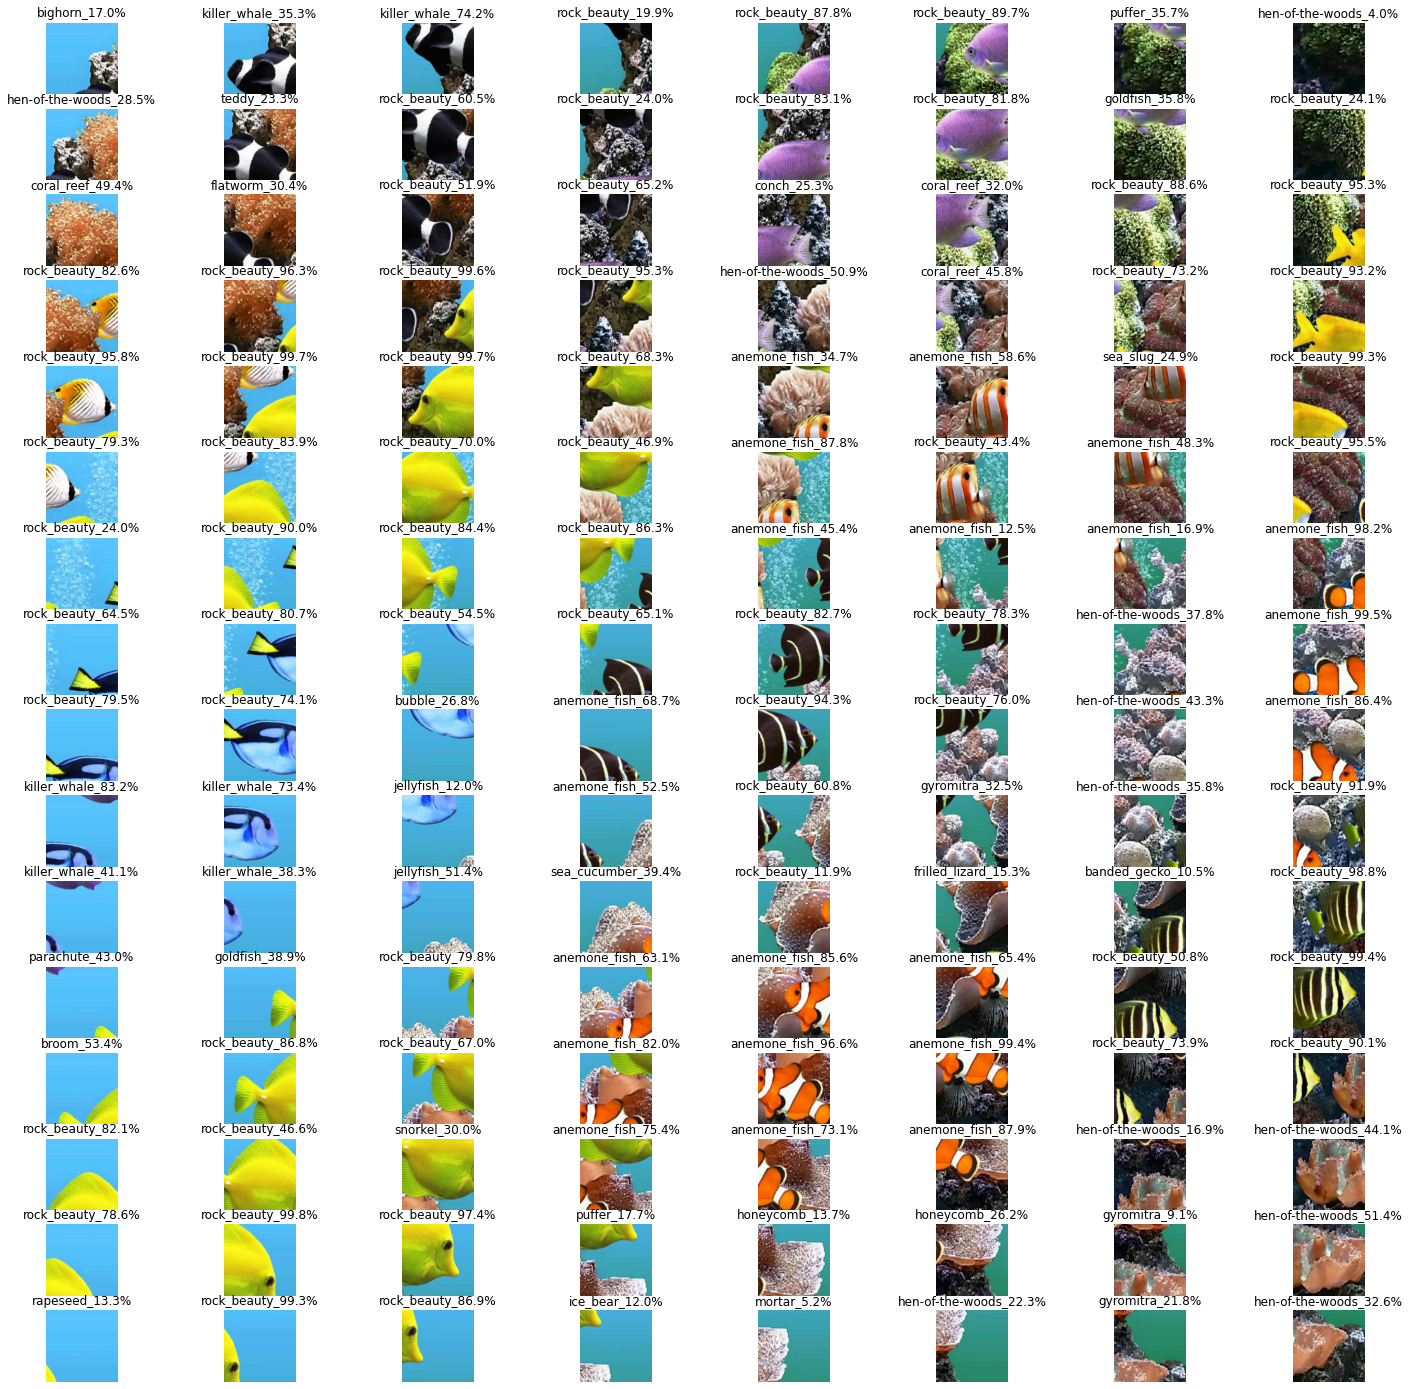

In [148]:
plt.figure(figsize=(35,25))
for tile, res, num in zip(tiles, result, range(len(tiles))):
  plt.subplot(16, int(len(tiles)/16), num+1)
  plt.title(f'{res[0][0:2][0][1]}_{round(res[0][0:2][0][2]*100, 1)}%')
  plt.imshow(tile/255.)
  plt.axis('off')

### It worked very well and we found our Nemo!

### To improve our model more we can train it on other pictures

### Upload pictures
We have small set of pictures downloaded from internet

In [145]:
train_gen = image.ImageDataGenerator(rescale=1/255.,
                                      rotation_range = 40,
                                      width_shift_range = 0.2,
                                      height_shift_range = 0.2,
                                      horizontal_flip = True,
                                      zoom_range = 0.2)
test_gen = image.ImageDataGenerator(rescale = 1/255.)

In [ ]:
train_data = train_gen.flow_from_directory(directory = '/content/10_food_classes_10_percent/train',
                                           target_size = (224, 224),
                                           class_mode = 'categorical',
                                           seed = 42)
test_data = test_gen.flow_from_directory('/content/10_food_classes_10_percent/test',
                                         target_size = (224, 224),
                                         seed = 42)